# Projet 2
## made by: José Lucas Barretto and Lucas Miguel Celinga Agrizzi

### Question 1)

Import the dataset and sort values based on the date:

In [1]:
import pandas as pd
import numpy as np

df = pd.read_excel('quarterly.xls', sheet_name = 'TB3MS')
df['DATE'] = pd.to_datetime(df.DATE)
df.sort_values('DATE', inplace=True)

Check for any missing dates/values in the dataset:

In [2]:
quarters = pd.date_range(start = df['DATE'][0], end = df['DATE'][len(df)-1], freq='QS')
missing_quarters = quarters.difference(df['DATE'])
print('missing quarters in the dataset? -', len(missing_quarters)!=0)
print('missing values in the dataset? -', df.isna().any().any())

missing quarters in the dataset? - False
missing values in the dataset? - False


### Question 2)

Calculate the quarterly inflation rate in %:

In [3]:
inf = df['CPI'].pct_change().dropna()*100
dates = df['DATE'][1:]

Plot the quarterly inflation rate through time:

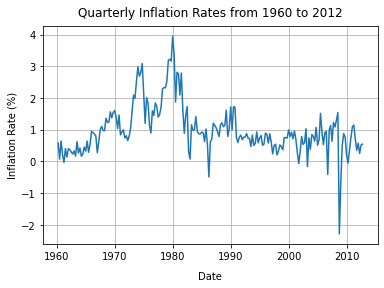

In [4]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(dates, inf)
plt.ylabel('Inflation Rate (%)')
plt.xlabel('Date', labelpad=10)
plt.title('Quarterly Inflation Rates from 1960 to 2012', pad=10)
plt.grid()
plt.show()

# MAKE COMMENTARY!!!!!!!!

### Question 3)

First, we're going to plot the autocorrelogram for *inf*. The idea here is to calculate the correlation between a time series observation and its previous values, which is called the autocorrelation. The autocorrelogram, thus, is just a plot of the autocorrelation by lag. To this end, we can use statsmodels' plot_acf function, which will also plot the region of confidence (values outside the blue region have confidence over 95%).

In our case, we want to see how the inflation rate of one quarter correlates with that of previous quarters.

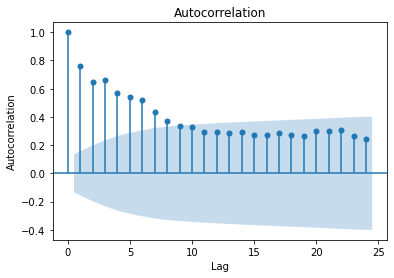

In [5]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots()
ax.set_title('Autocorrelogram for Quarterly Inflation Rates', pad=10)
ax.set_ylabel('Autocorrelation')
ax.set_xlabel('Lag')
plot_acf(inf, ax = ax)
plt.show()

We can see in the autocorrelogram above that the inflation rate of a quarter is highly correlated (> 0.5) with those of the 5 previous quarters. Also, since these autocorrelation values are outside the blue region, they have a high statistical confidence (over 95%).

Now, let's plot the partial autocorrelogram. The idea behing the partial autocorrelogram of a time series to obtain the conditional correlation between the observation at time t and the observation at time t-h (lag h), given that we observed what we observed in all timesteps between t and h. Therefore, the partial autocorrelation aims to remove the effects of the observations between the current observation and the observation at lag h, which also means that it removes indirect correlations that are included in the autocorrelogram.

Due to this property, for an AR model of order k, the partial autocorrelations are 0 for every lag beyond k. We can use this information to estimate the order of an AR model by counting the number of lags with non-zero partial autocorrelation.

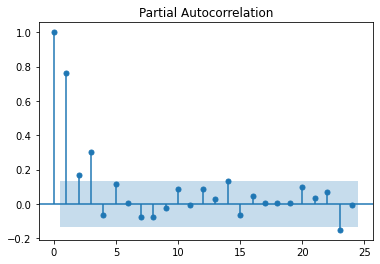

In [6]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(inf)
plt.show()

From the partial autocorrelogram above, we can see that the partial autocorrelation is statistically significant for lags up to 3 (values outside the blue region, which means confidence over 95%), which could suggest an AR model of order k=3 to predict the inflation.

### Question 4)

In time series analysis, **stationarity** means that the joint distribution for random variables at times $(Y_{s+1}, Y_{s+2}, ..., Y_{s+T})$ does not depend on $s$. This means that the distribution of the processe's variables does not vary over time. 

On the other hand, **ergodicity** means that the process does not depend on initial conditions, and that we can deduce statistical properties given sufficient random samples of a process.

If both of these conditions are satisfied, and the mean of variables is not infinite, then the temporal mean is equal to the spatial mean.

$$
E(Y_t) = \frac{1}{T} \sum_{t=1}^{T}Y_t \rightarrow \mu
$$

A **spurious regression** is a problem that happens when a regression shows evidence of a non-existing relationship between two variables. This means that the regression coefficient estimate should be zero (because the two variables are uncorrelated), but the regression returns a statistically significant value that is not zero, but has a high $R^2$ value (generalizes very badly). This can happen, if the time series are random walks, which are non-stationary .

### Question 5)

We want to find the value of p that produces the best AR(p) model for the inflation values. We can do this by testing multiple AR(p) models, with varying values for p, and choosing the value that generates the model with lowest AIC value (which measures model quality while taking complexity into account).

In [76]:
import warnings
from statsmodels.tsa.api import AutoReg

# disable warnings for improved visualization of the results
warnings.filterwarnings('ignore')

# test AR(p) models for different values of p
max_p = 7
results = {}
for lag in range(1, max_p):
    # fit the model
    model = AutoReg(inf, lags=lag).fit()
    
    # save results into a dict
    results[lag] = [model.aic, model.bic]
    print('lags:', lag, '- AIC:', model.aic, '- BIC:', model.bic)

# choose the value of p that generates the AR(p) with lowest AIC values
best_lag = min(results, key = lambda k: results[k][0])
print('lag value with lowest AIC:', best_lag)

# build the model with the obtained value for p
model = AutoReg(inf, lags=best_lag)
model_results = model.fit()
print('\n', model_results.summary())

lags: 1 - AIC: -1.3546907748283459 - BIC: -1.3068749529609534
lags: 2 - AIC: -1.3771598479087657 - BIC: -1.3131917282539367
lags: 3 - AIC: -1.457867594311414 - BIC: -1.3776383135493633
lags: 4 - AIC: -1.451937606983782 - BIC: -1.3553370622514525
lags: 5 - AIC: -1.4533109129135484 - BIC: -1.3402277421294364
lags: 6 - AIC: -1.4384124181490383 - BIC: -1.308733979938759
lag value with lowest AIC: 3

                             AutoReg Model Results                             
Dep. Variable:                    CPI   No. Observations:                  211
Model:                     AutoReg(3)   Log Likelihood                -138.521
Method:               Conditional MLE   S.D. of innovations              0.471
Date:                Thu, 19 Nov 2020   AIC                             -1.458
Time:                        18:14:21   BIC                             -1.378
Sample:                             3   HQIC                            -1.425
                                  211          

### Question 6)

The Phillips Curve model is a simple static time-series model that expresses the unemployment rate at a time $t$ in function of the inflation rate at the same time $t$: 

*unemployment rate*$_t$ = $\beta_0 + \beta_1$*inflation*$_t + u_t$

We can build this using the OLS model from the statsmodels package.

In [17]:
from statsmodels.api import OLS

y = df['Unemp'][1:]
const = np.ones(y.shape)
X = np.column_stack((const, inf))

phillips = OLS(y, X)
phillips_results = phillips.fit()
print(phillips_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Unemp   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                   0.01214
Date:                Thu, 19 Nov 2020   Prob (F-statistic):              0.912
Time:                        15:51:48   Log-Likelihood:                -400.28
No. Observations:                 211   AIC:                             804.6
Df Residuals:                     209   BIC:                             811.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0708      0.181     33.576      0.0

We can plot the OLS predictions to see how it fit the data we used.

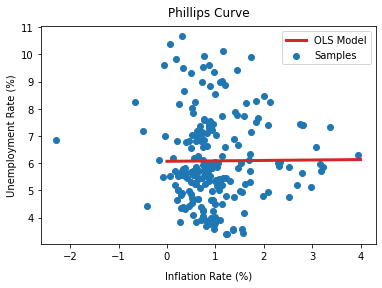

In [72]:
# generate model predictions on a linspace of inflation values
inf_samples = np.linspace(0,4,100)
const = np.ones(inf_samples.size)
X_samples = np.column_stack((const, inf_samples))

pred = phillips_results.predict(X_samples)

# plot the original samples and the OLS predictions
plt.figure()
plt.plot(inf_samples, pred, c='tab:red', lw=3, label='OLS Model')
plt.scatter(inf, y, label='Samples')
plt.legend()
plt.title('Phillips Curve', pad=10)
plt.xlabel('Inflation Rate (%)', labelpad=10)
plt.ylabel('Unemployment Rate (%)')
plt.show()

### Question 7)

First, let's visualize the errors (or residuals) of the OLS model.

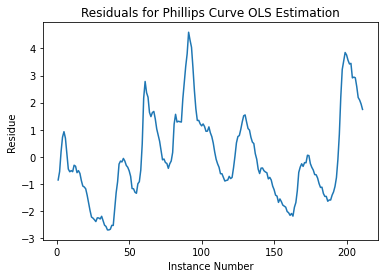

In [73]:
# obtain residuals from OLS model
residuals = phillips_results.resid

# plot residuals
plt.figure()
plt.title('Residuals for Phillips Curve OLS Estimation')
plt.xlabel('Instance Number')
plt.ylabel('Residue')
plt.plot(residuals)
plt.show()

Now, we want to verify if errors are autocorrelated. To this end, we can test the hypothesis $H_0$ that the errors are serially uncorrelated. For an AR(1) model, $u_t = \rho u_{t-1} + e_t$, this hypothesis can be translated to:

$$
H_0: \rho = 0
$$

Therefore, we can fit an AR(1) model to the residuals of the Phillips Curve OLS Estimator and check the t-value for $\rho$ to test the null hypothesis.

In [46]:
residuals_ar = AutoReg(residuals, lags=1)
residuals_ar_results = residuals_ar.fit()
print(residuals_ar_results.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  211
Model:                     AutoReg(1)   Log Likelihood                 -70.272
Method:               Conditional MLE   S.D. of innovations              0.338
Date:                Thu, 19 Nov 2020   AIC                             -2.140
Time:                        17:22:26   BIC                             -2.092
Sample:                             1   HQIC                            -2.121
                                  211                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0122      0.023      0.524      0.601      -0.034       0.058
y.L1           0.9800      0.014     67.714      0.000       0.952       1.008
                                    Roots           

We can see that the p-value for the coefficient $\rho$ (appears as y.L1 in the model's summary) is approximately 0. Therefore, we reject the null hypothesis that the errors are serially uncorrelated at 5%, and conclude that the errors and autocorrelated.

###  Question 8)

To correct the issue of error autocorrelation, we can build the following regression:

$$
\tilde{y_t} - \rho y_{t-1} = \beta_0(1-\rho) + \beta_1(\tilde{x_t}) + e_t
$$

Where $\tilde{y_t} = y_t - \rho y_{t-1}$ and $\tilde{x_t} = x_t - \rho x_{t-1}$.

In [74]:
# obtain the rho value for the residuals AR(1) model
rho = residuals_ar_results.params[1]

# create y_hat variable
y = df['Unemp'][1:].to_numpy()
y_t1 = y[1:]
y_t0 = y[:-1]

y_hat = y_t1 - rho*y_t0

# create x_hat variable
x = inf.to_numpy()
x_t1 = x[1:]
x_t0 = x[:-1]

x_hat = x_t1 - rho*x_t0
const_hat = np.ones(x_hat.shape) - rho
X_hat = np.column_stack((const_hat, x_hat))

# regress y_hat on x_hat
phillips_correction = OLS(y_hat, X_hat)
phillips_correction_results = phillips_correction.fit()
print(phillips_correction_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     5.203
Date:                Thu, 19 Nov 2020   Prob (F-statistic):             0.0236
Time:                        18:06:00   Log-Likelihood:                -66.797
No. Observations:                 210   AIC:                             137.6
Df Residuals:                     208   BIC:                             144.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             6.7936      1.152      5.899      0.0

Again, we can plot the OLS predictions to see how it fit the data we used, this time using the estimator with correction for autocorrelated errors.

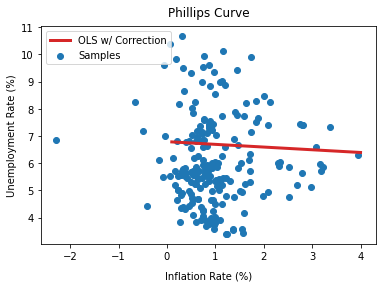

In [75]:
# generate model predictions on a linspace of inflation values
inf_samples = np.linspace(0.1,4,100)
const = np.ones(inf_samples.size)
X_samples = np.column_stack((const, inf_samples))

pred = phillips_correction_results.predict(X_samples)

# plot the original samples and the predictions from the OLS w/ correction for autocorrelated error
plt.figure()
plt.plot(inf_samples, pred, c='tab:red', lw=3, label='OLS w/ Correction')
plt.scatter(inf, y, label='Samples')
plt.legend(loc='upper left')
plt.title('Phillips Curve', pad=10)
plt.xlabel('Inflation Rate (%)', labelpad=10)
plt.ylabel('Unemployment Rate (%)')
plt.show()